# Regularization for a classifier of the cat/dog data

## Plot functions for training evaluation
These function will provide performance curves for each epoch of the training process. This will allow us later to judge if overfitting occured or not and if our regularization approaches were successful.

In [6]:
import matplotlib.pyplot as plt

def plot_histories(histories, keys=['loss', 'acc']):
    fig, axs = plt.subplots(len(keys), 1, figsize=(20,16))
    #fig.figsize=(20,16)
    if len(keys) == 1:
        axs = [axs]
    # one plot for each specified key
    for i, ax in enumerate(axs):
        key = keys[i]
        for name, history in histories:
            val = ax.plot(history.epoch, history.history['val_'+key],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history[key], color=val[0].get_color(),
                    label=name.title()+' Train')

        ax.set_xlabel('Epochs')
        ax.set_ylabel(key.replace('_',' ').title())
        ax.legend()
        ax.set_title(key)
        ax.set_xlim([0,max(history.epoch)])
    plt.show()

## Setting input paths

In [7]:
import numpy as np

In [11]:
import os

os.getcwd()

'/home/h0/s1228964/Playground/deeplearning18/day2/notebooks'

In [22]:
# TODO: maybe have to adjust the base_dir if IO error occurs
base_dir = os.path.join('..','..', 'data','cats-dogs')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [24]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total validation dog images: 400


## Setting up the input pipeline 

In [25]:
# this is the augmentation configuration we will use for training
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [26]:
batch_size = 64

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## The baseline model
Our first model whose performance we will try to improve by means of regularization.
We will see that it is powerful enough to classify the training data perfectly. But this is of course not our main goal. So maybe it is already to powerful (in terms of parameters)?

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

def get_baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [28]:
m_base = get_baseline_model()
#m_base = get_baseline_model_cnn()
print(m_base.summary())

W1009 01:08:51.836302 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 01:08:51.851835 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 01:08:51.853532 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1009 01:08:51.866318 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [30]:
from keras import optimizers

m_base.compile(optimizer='rmsprop',
               loss="binary_crossentropy", 
               metrics=['accuracy'])

W1009 01:09:01.978969 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1009 01:09:02.004971 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1009 01:09:02.009408 35184372383184 deprecation.py:323] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Start training

In [31]:
epochs = 20

hist_base = m_base.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

W1009 01:09:05.116177 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/20
31/31 [==============================] - 36s 1s/step - loss: 0.7613 - acc: 0.5025 - val_loss: 0.7278 - val_acc: 0.4987
Epoch 2/20
31/31 [==============================] - 7s 231ms/step - loss: 0.6918 - acc: 0.5307 - val_loss: 0.6736 - val_acc: 0.5707
Epoch 3/20
31/31 [==============================] - 7s 240ms/step - loss: 0.6784 - acc: 0.6057 - val_loss: 0.6939 - val_acc: 0.5421
Epoch 4/20
31/31 [==============================] - 8s 258ms/step - loss: 0.6706 - acc: 0.5877 - val_loss: 0.6716 - val_acc: 0.6372
Epoch 5/20
31/31 [==============================] - 7s 241ms/step - loss: 0.6066 - acc: 0.6613 - val_loss: 0.6127 - val_acc: 0.6861
Epoch 6/20
31/31 [==============================] - 8s 256ms/step - loss: 0.5919 - acc: 0.6794 - val_loss: 0.5867 - val_acc: 0.6875
Epoch 7/20
31/31 [==============================] - 8s 245ms/step - loss: 0.5593 - acc: 0.7132 - val_loss: 0.6089 - val_acc: 0.6780
Epoch 8/20
31/31 [==============================] - 8s 250ms/step - loss: 0.52

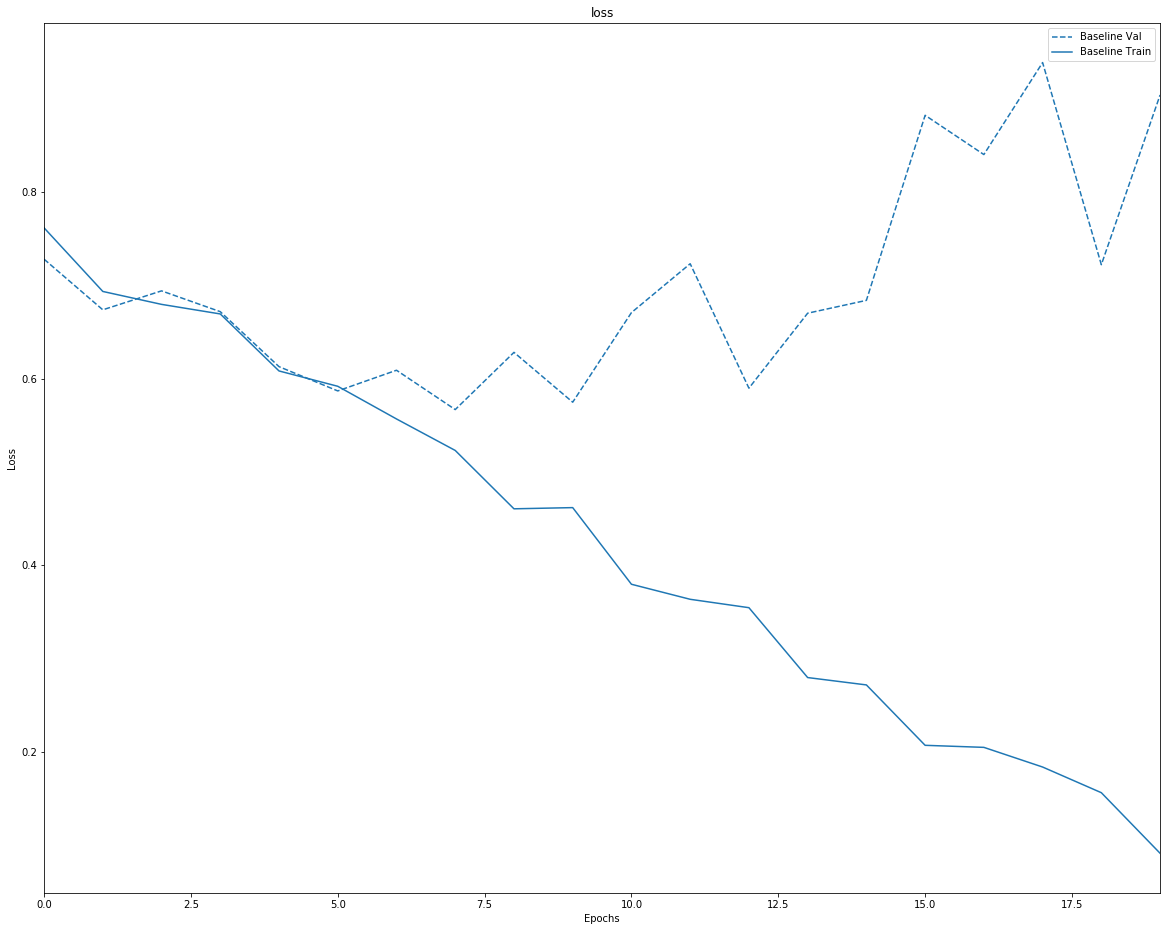

In [32]:
plot_histories([('baseline', hist_base)], keys=['loss'])

# Adjust model size

## smaller model

Since the baseline model is able to classify the training data almost perfectly, we will try to lessen its capacity by reducing the number of parameters, hoping to reduce the amount of overfitting. 


In [33]:
def get_smaller_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # conv block with only half as many filters
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [34]:
m_small = get_smaller_model()
print(m_small.summary())

m_small.compile(optimizer='rmsprop',
               loss="binary_crossentropy", 
               metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 32)        9248      
__________

In [35]:
hist_small = m_small.fit_generator(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch=2000 // batch_size,
                                   validation_data=validation_generator,
                                   validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 8s 252ms/step - loss: 0.7328 - acc: 0.5086 - val_loss: 0.6822 - val_acc: 0.5462
Epoch 2/20
31/31 [==============================] - 8s 249ms/step - loss: 0.6846 - acc: 0.5745 - val_loss: 0.6499 - val_acc: 0.6332
Epoch 3/20
31/31 [==============================] - 8s 246ms/step - loss: 0.6494 - acc: 0.6471 - val_loss: 0.6223 - val_acc: 0.7011
Epoch 4/20
31/31 [==============================] - 8s 265ms/step - loss: 0.6082 - acc: 0.6724 - val_loss: 0.6007 - val_acc: 0.7052
Epoch 5/20
31/31 [==============================] - 8s 248ms/step - loss: 0.5731 - acc: 0.7136 - val_loss: 0.5699 - val_acc: 0.6929
Epoch 6/20
31/31 [==============================] - 8s 249ms/step - loss: 0.5222 - acc: 0.7379 - val_loss: 0.6109 - val_acc: 0.6562
Epoch 7/20
31/31 [==============================] - 7s 239ms/step - loss: 0.5045 - acc: 0.7596 - val_loss: 0.6740 - val_acc: 0.6535
Epoch 8/20
31/31 [==============================] - 8s 248ms/step - loss: 0.

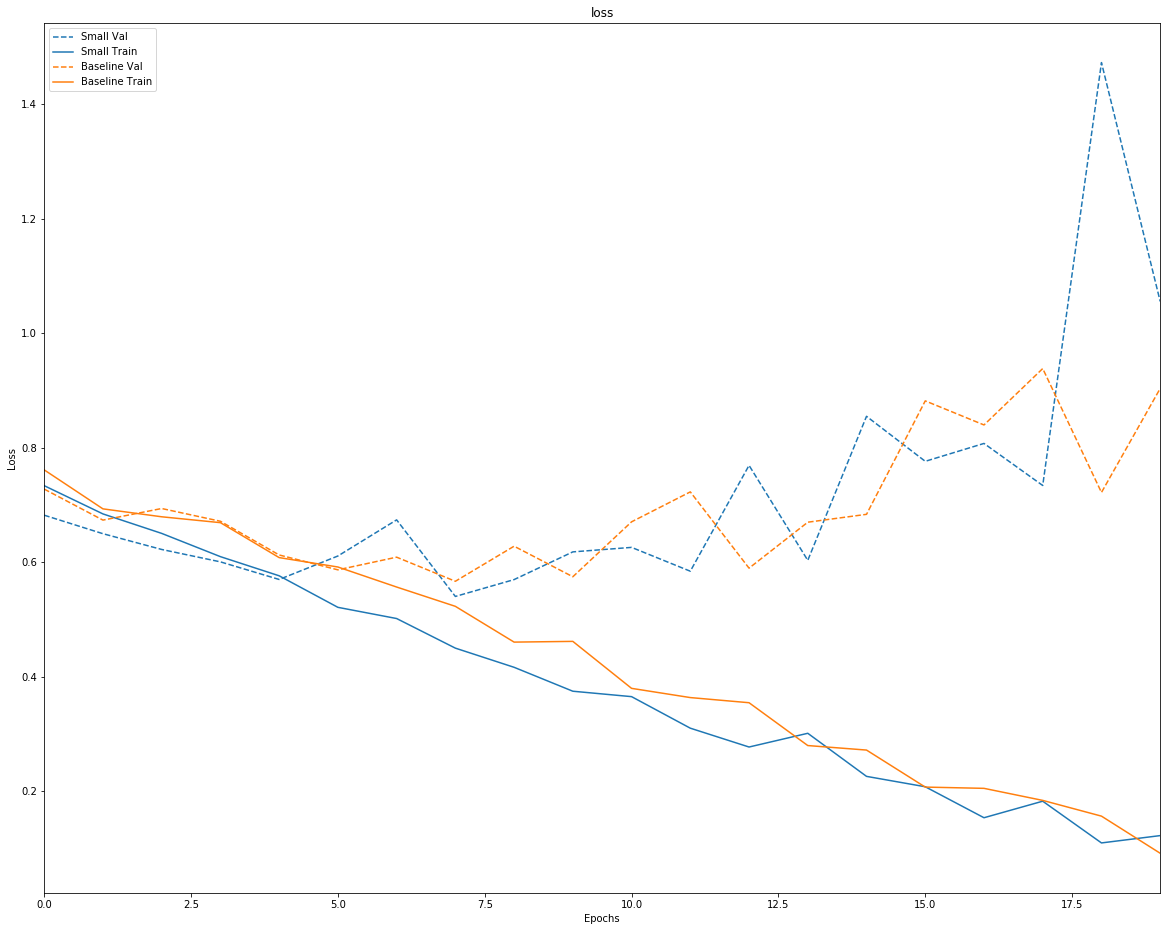

In [36]:
plot_histories([('small', hist_small),
                ('baseline', hist_base), ], keys=['loss'])

## larger model

By making the model larger we expect to see an even more extreme form of overfitting.

In [37]:
def get_larger_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    # twice as many fc neurons here!
    model.add(Dense(128))
    model.add(Activation('relu'))
    # and another dense layer!
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [38]:
m_large = get_larger_model()
print(m_large.summary())

m_large.compile(optimizer='rmsprop',
                loss="binary_crossentropy", 
                metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [39]:
hist_large = m_large.fit_generator(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch=2000 // batch_size,
                                   validation_data=validation_generator,
                                   validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 8s 257ms/step - loss: 0.7688 - acc: 0.5084 - val_loss: 0.6850 - val_acc: 0.5231
Epoch 2/20
31/31 [==============================] - 8s 249ms/step - loss: 0.6965 - acc: 0.5417 - val_loss: 0.6786 - val_acc: 0.6185
Epoch 3/20
31/31 [==============================] - 9s 284ms/step - loss: 0.6628 - acc: 0.6013 - val_loss: 0.6301 - val_acc: 0.6630
Epoch 4/20
31/31 [==============================] - 8s 245ms/step - loss: 0.6462 - acc: 0.6458 - val_loss: 0.6581 - val_acc: 0.5951
Epoch 5/20
31/31 [==============================] - 7s 242ms/step - loss: 0.5907 - acc: 0.6800 - val_loss: 0.5892 - val_acc: 0.6576
Epoch 6/20
31/31 [==============================] - 7s 232ms/step - loss: 0.5390 - acc: 0.7338 - val_loss: 0.5788 - val_acc: 0.7106
Epoch 7/20
31/31 [==============================] - 7s 224ms/step - loss: 0.5218 - acc: 0.7455 - val_loss: 0.5927 - val_acc: 0.7079
Epoch 8/20
31/31 [==============================] - 8s 260ms/step - loss: 0.

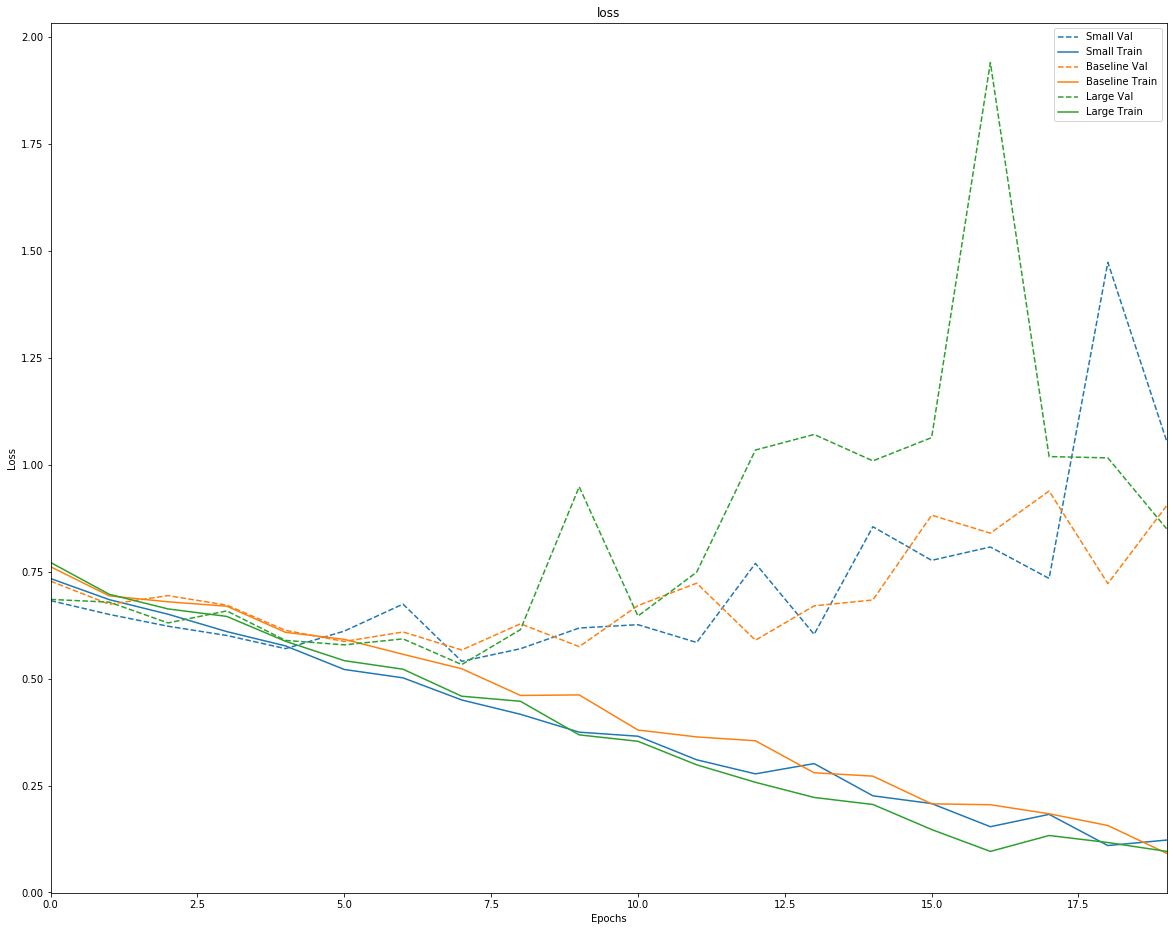

In [40]:
plot_histories([('small', hist_small),
                ('baseline', hist_base), 
                ('large', hist_large)], keys=['loss'])

## Using "early stopping"

The idea here is to stop the training procedure before the model starts to adapt too much on the training samples. We go on as long as the validation loss drops by at least 0.1 and stop if it does not do so during 5 consecutive training epochs.

Note: This is a kind of data snooping since information of the validation set is used during training which should in general be a no-go. We show it here for demonstration only! The way to go would be to divide your data into training, validation and test set and do the early stopping based on the loss on the validation set. After the model is then trained, you should validate it on the test set which has not been looked at before.

In [41]:
from keras.callbacks import EarlyStopping

m_base = get_baseline_model()

m_base.compile(optimizer="rmsprop",
               #optimizers.Adadelta(),
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_earlystop = m_base.fit_generator(train_generator,
                                      epochs=epochs,
                                      steps_per_epoch=2000 // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=800 // batch_size,
                                      callbacks=[
                                          EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)])

Epoch 1/20
31/31 [==============================] - 8s 270ms/step - loss: 0.7269 - acc: 0.4934 - val_loss: 0.6848 - val_acc: 0.5245
Epoch 2/20
31/31 [==============================] - 8s 244ms/step - loss: 0.6902 - acc: 0.5580 - val_loss: 0.7422 - val_acc: 0.4891
Epoch 3/20
31/31 [==============================] - 8s 259ms/step - loss: 0.6698 - acc: 0.6317 - val_loss: 0.6386 - val_acc: 0.6304
Epoch 4/20
31/31 [==============================] - 8s 269ms/step - loss: 0.6200 - acc: 0.6684 - val_loss: 0.5979 - val_acc: 0.6671
Epoch 5/20
31/31 [==============================] - 8s 245ms/step - loss: 0.5740 - acc: 0.7091 - val_loss: 0.5719 - val_acc: 0.6861
Epoch 6/20
31/31 [==============================] - 8s 245ms/step - loss: 0.5499 - acc: 0.7233 - val_loss: 0.5765 - val_acc: 0.7120
Epoch 7/20
31/31 [==============================] - 8s 260ms/step - loss: 0.4936 - acc: 0.7692 - val_loss: 0.5599 - val_acc: 0.7160
Epoch 8/20
31/31 [==============================] - 9s 277ms/step - loss: 0.

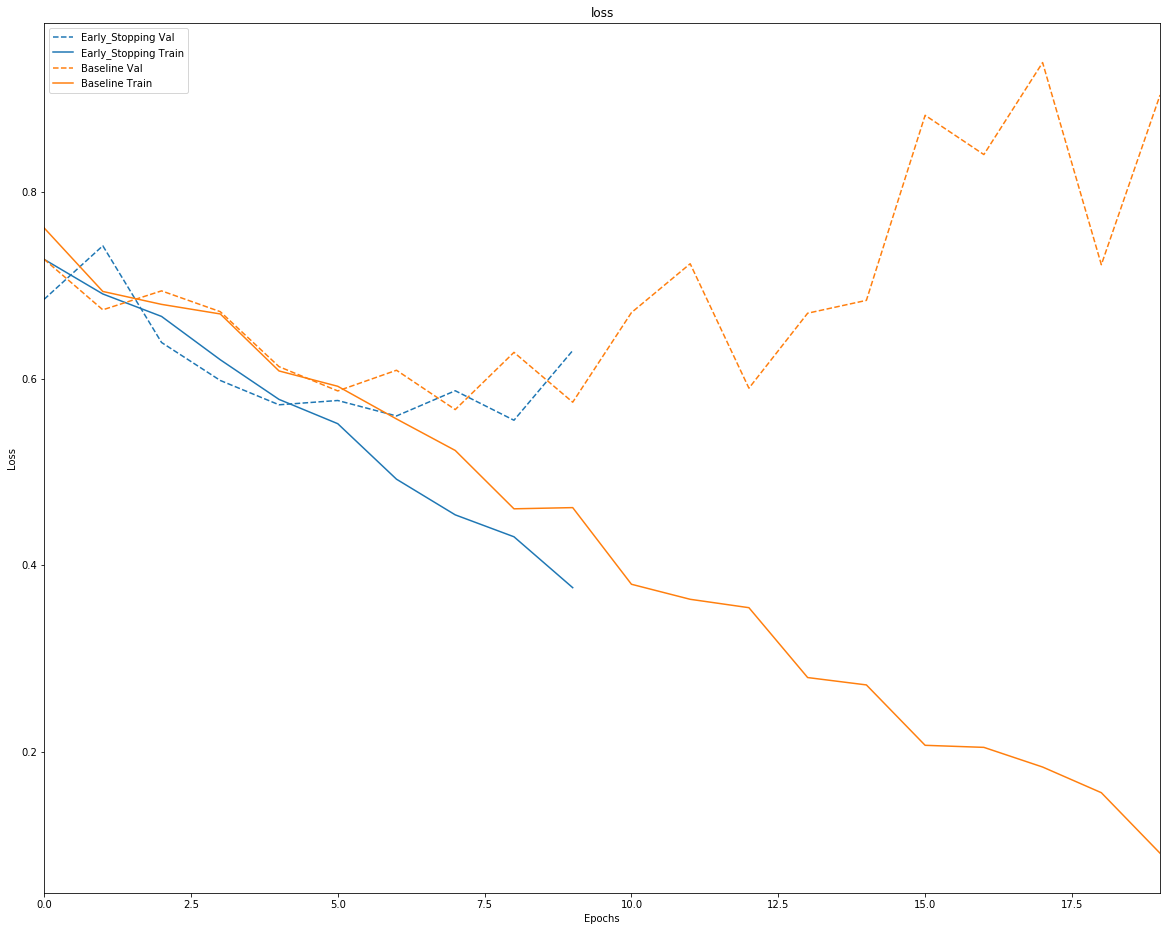

In [42]:
plot_histories([('early_stopping', hist_earlystop), 
                ('baseline', hist_base)], keys=['loss'])

## Weight regularisation

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's try both flavors now.

### Using L1 regularization

In [43]:
# copy-paste the baseline model, but add regularization terms to each layer
from keras import regularizers

reg_weight = 1.e-4

def get_l1_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(reg_weight), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('sigmoid'))
    
    return model

```l1(0.001)``` means that every coefficient in the weight matrix of the layer will add ```0.001 * abs(weight_coefficient_value)``` to the total loss of the network.

In [44]:
m_l1 = get_l1_model()

m_l1.compile(optimizer="rmsprop",
             loss="binary_crossentropy", 
             metrics=['accuracy'])

hist_l1 = m_l1.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 9s 277ms/step - loss: 1.0913 - acc: 0.5251 - val_loss: 1.0039 - val_acc: 0.4946
Epoch 2/20
31/31 [==============================] - 8s 247ms/step - loss: 0.8502 - acc: 0.5464 - val_loss: 0.7994 - val_acc: 0.6046
Epoch 3/20
31/31 [==============================] - 8s 243ms/step - loss: 0.7804 - acc: 0.5998 - val_loss: 0.7449 - val_acc: 0.6264
Epoch 4/20
31/31 [==============================] - 8s 250ms/step - loss: 0.7745 - acc: 0.6119 - val_loss: 0.7538 - val_acc: 0.6087
Epoch 5/20
31/31 [==============================] - 7s 239ms/step - loss: 0.7513 - acc: 0.6330 - val_loss: 0.7159 - val_acc: 0.6508
Epoch 6/20
31/31 [==============================] - 7s 241ms/step - loss: 0.7383 - acc: 0.6382 - val_loss: 0.7193 - val_acc: 0.6644
Epoch 7/20
31/31 [==============================] - 8s 252ms/step - loss: 0.7333 - acc: 0.6543 - val_loss: 0.6954 - val_acc: 0.6807
Epoch 8/20
31/31 [==============================] - 8s 259ms/step - loss: 0.

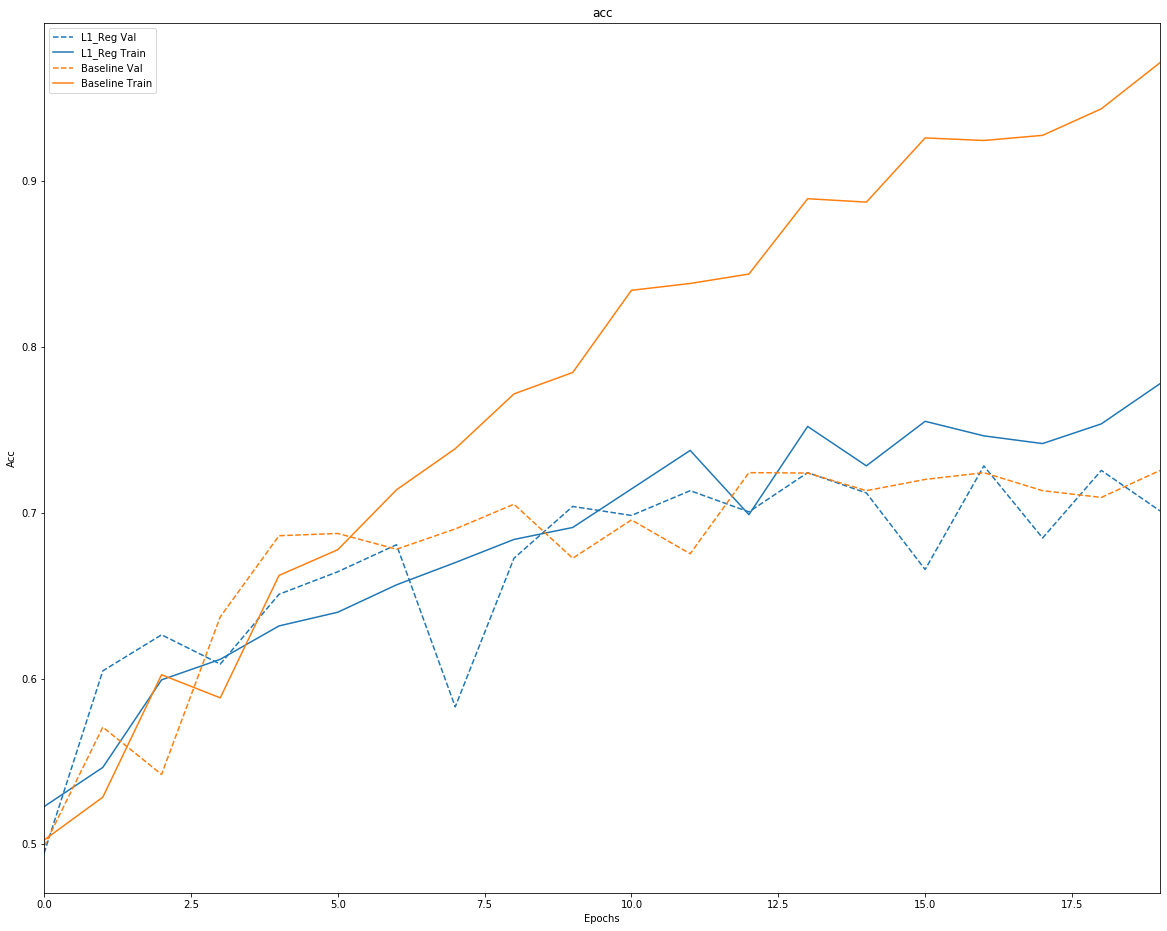

In [67]:
plot_histories([('l1_reg', hist_l1), 
                ('baseline', hist_base)], keys=['acc'])

Note that because this penalty is only added at training time, the loss for this network will be higher at training than at test time.


### Using L2 regularization

In [46]:
# copy-paste the baseline model, but add regularization terms to each layer
from keras import regularizers

reg_weight = 1.e-4

def get_l2_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(reg_weight), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('sigmoid'))
    return model

In [47]:
m_l2 = get_l2_model()

m_l2.compile(optimizer="rmsprop",
             loss="binary_crossentropy", 
             metrics=['accuracy'])

hist_l2 = m_l2.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=2000 // batch_size,
                             validation_data=validation_generator,
                             validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 8s 269ms/step - loss: 0.8880 - acc: 0.5282 - val_loss: 0.6991 - val_acc: 0.5299
Epoch 2/20
31/31 [==============================] - 8s 256ms/step - loss: 0.7012 - acc: 0.5581 - val_loss: 0.6729 - val_acc: 0.5761
Epoch 3/20
31/31 [==============================] - 8s 254ms/step - loss: 0.6664 - acc: 0.6125 - val_loss: 0.6845 - val_acc: 0.5802
Epoch 4/20
31/31 [==============================] - 8s 257ms/step - loss: 0.6236 - acc: 0.6676 - val_loss: 0.6035 - val_acc: 0.6685
Epoch 5/20
31/31 [==============================] - 8s 265ms/step - loss: 0.5886 - acc: 0.7112 - val_loss: 0.5884 - val_acc: 0.6929
Epoch 6/20
31/31 [==============================] - 7s 237ms/step - loss: 0.5693 - acc: 0.7151 - val_loss: 0.5869 - val_acc: 0.7052
Epoch 7/20
31/31 [==============================] - 8s 247ms/step - loss: 0.5336 - acc: 0.7484 - val_loss: 0.5921 - val_acc: 0.7005
Epoch 8/20
31/31 [==============================] - 7s 239ms/step - loss: 0.

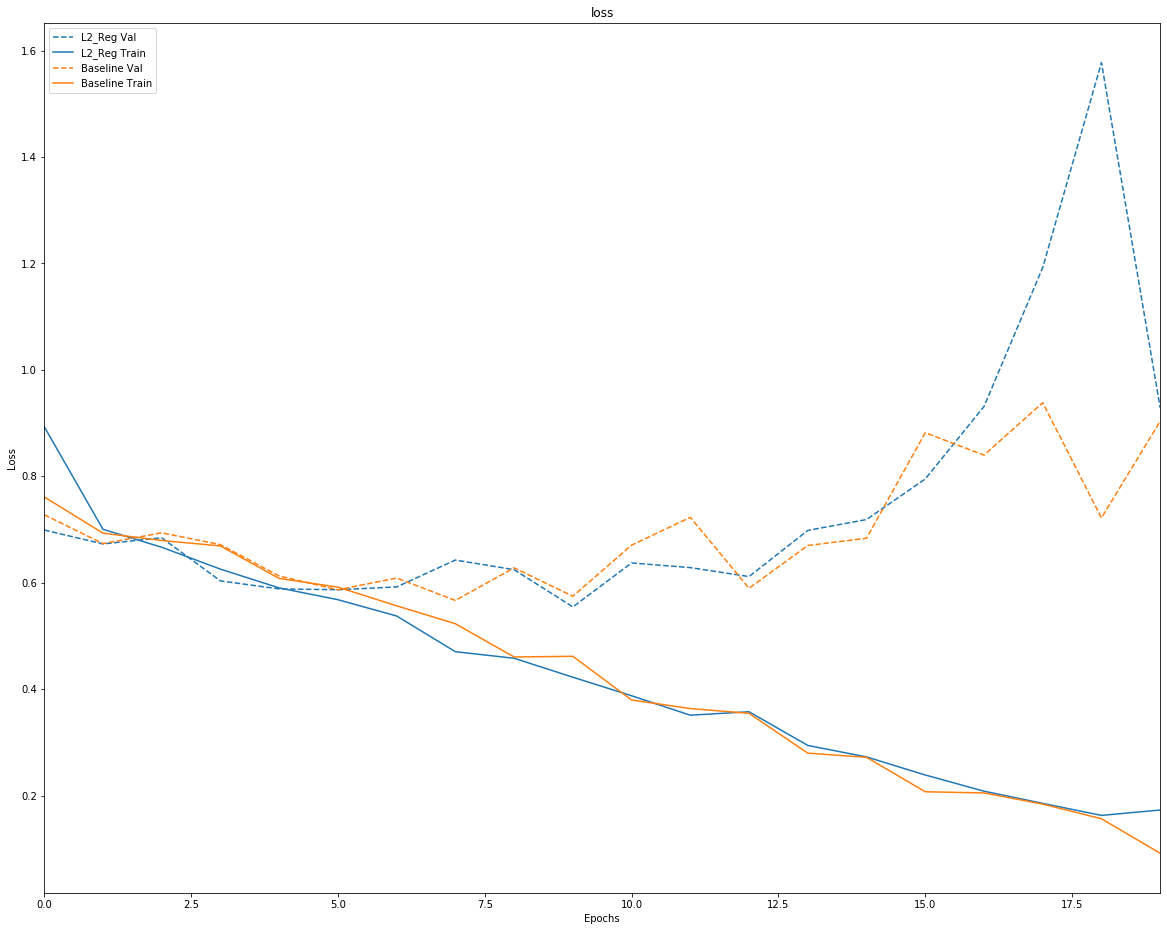

In [48]:
plot_histories([('l2_reg', hist_l2), 
                ('baseline', hist_base)], keys=['loss'])

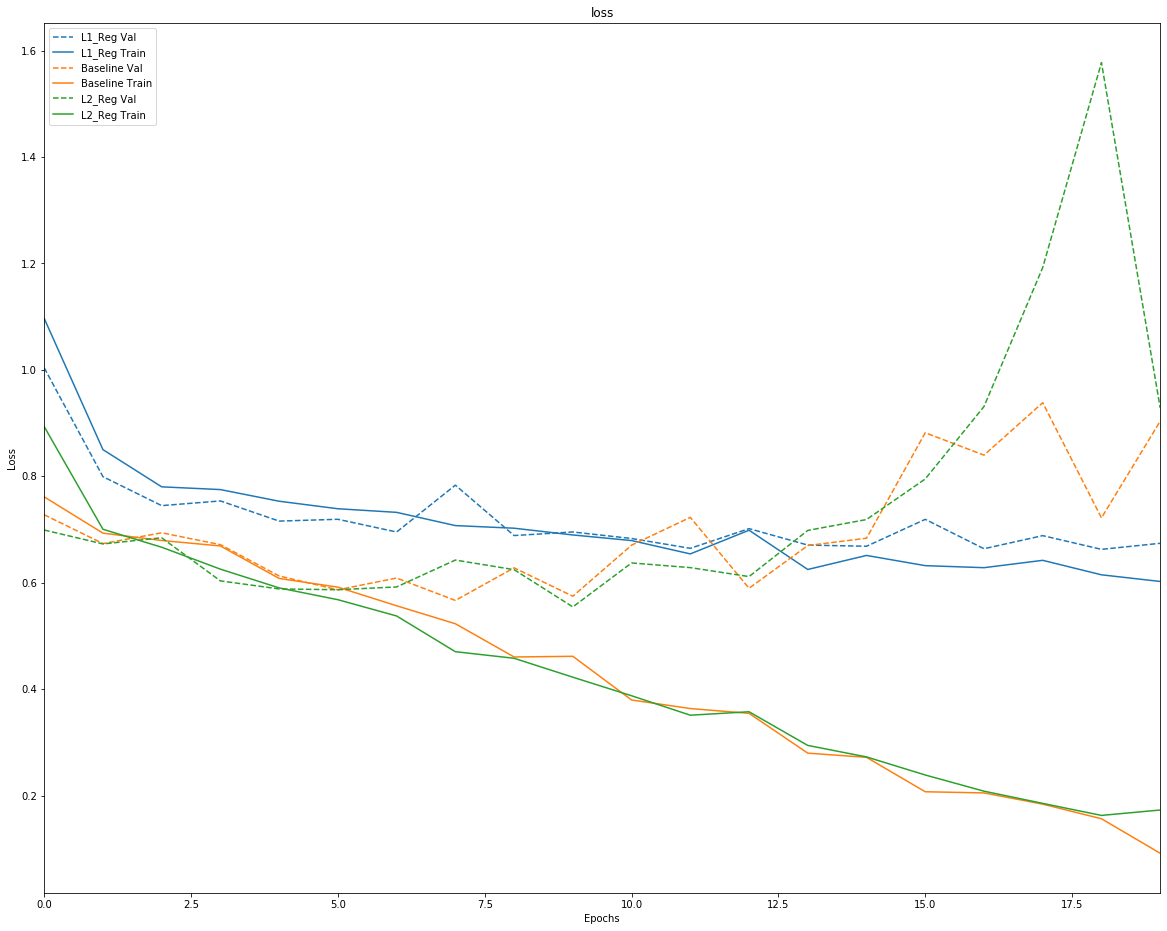

In [49]:
plot_histories([('l1_reg', hist_l1), 
                ('baseline', hist_base),
                ('l2_reg', hist_l2)], keys=['loss'])

### Using L1 and L2 regularization

In [50]:
reg_weight = 1.e-4

def get_l1_l2_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight), 
                     input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('sigmoid'))

    
    return model

In [51]:
m_l1l2 = get_l1_l2_model()

m_l1l2.compile(optimizer="rmsprop",
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_l1l2 = m_l1l2.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 8s 261ms/step - loss: 1.2983 - acc: 0.4951 - val_loss: 0.9987 - val_acc: 0.6068
Epoch 2/20
31/31 [==============================] - 8s 244ms/step - loss: 0.9325 - acc: 0.5232 - val_loss: 0.8748 - val_acc: 0.5109
Epoch 3/20
31/31 [==============================] - 8s 249ms/step - loss: 0.8405 - acc: 0.5593 - val_loss: 0.7961 - val_acc: 0.6372
Epoch 4/20
31/31 [==============================] - 8s 249ms/step - loss: 0.7862 - acc: 0.5812 - val_loss: 0.7743 - val_acc: 0.6209
Epoch 5/20
31/31 [==============================] - 7s 241ms/step - loss: 0.7848 - acc: 0.5732 - val_loss: 0.7342 - val_acc: 0.6413
Epoch 6/20
31/31 [==============================] - 8s 269ms/step - loss: 0.7578 - acc: 0.6088 - val_loss: 0.7251 - val_acc: 0.6291
Epoch 7/20
31/31 [==============================] - 7s 235ms/step - loss: 0.7353 - acc: 0.6355 - val_loss: 0.7426 - val_acc: 0.5897
Epoch 8/20
31/31 [==============================] - 7s 238ms/step - loss: 0.

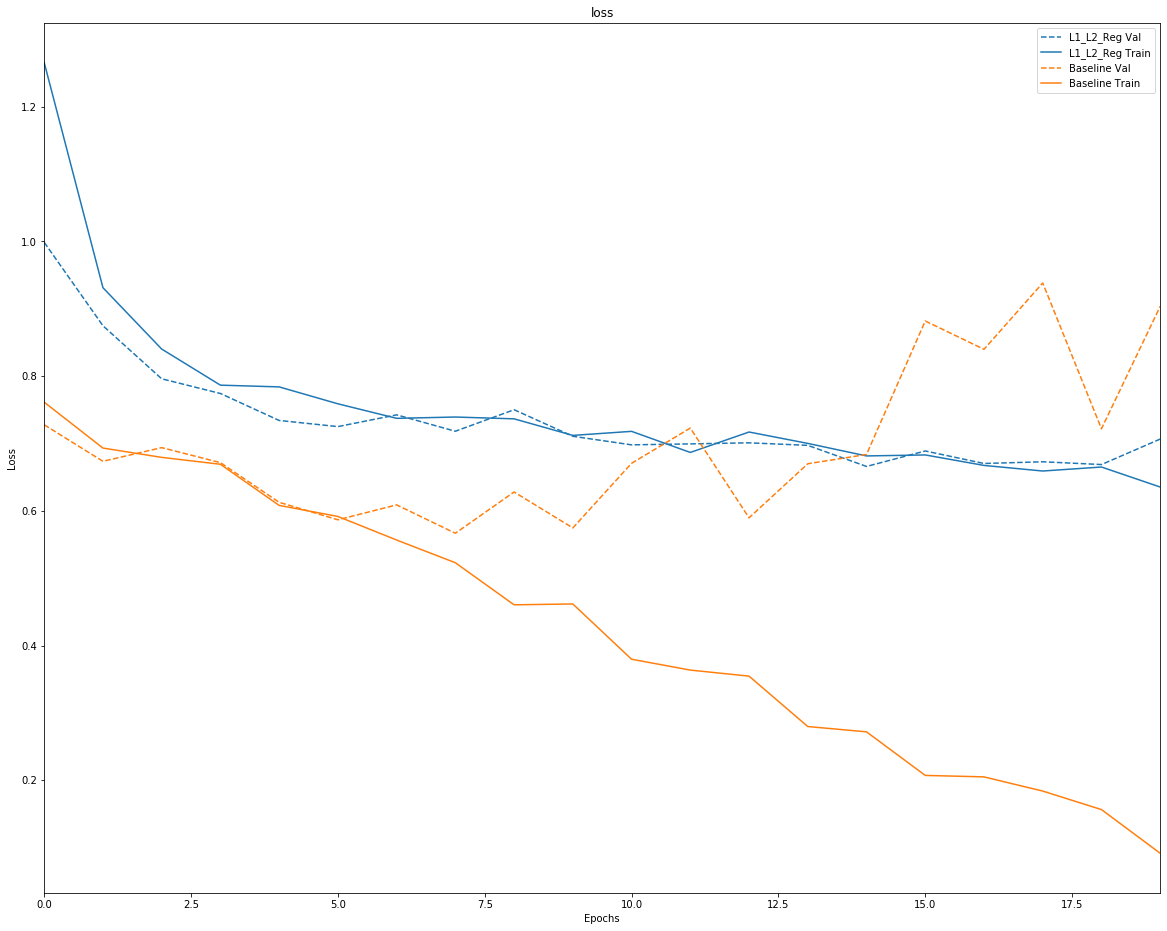

In [52]:
plot_histories([('l1_l2_reg', hist_l1l2), 
                ('baseline', hist_base)], keys=['loss'])

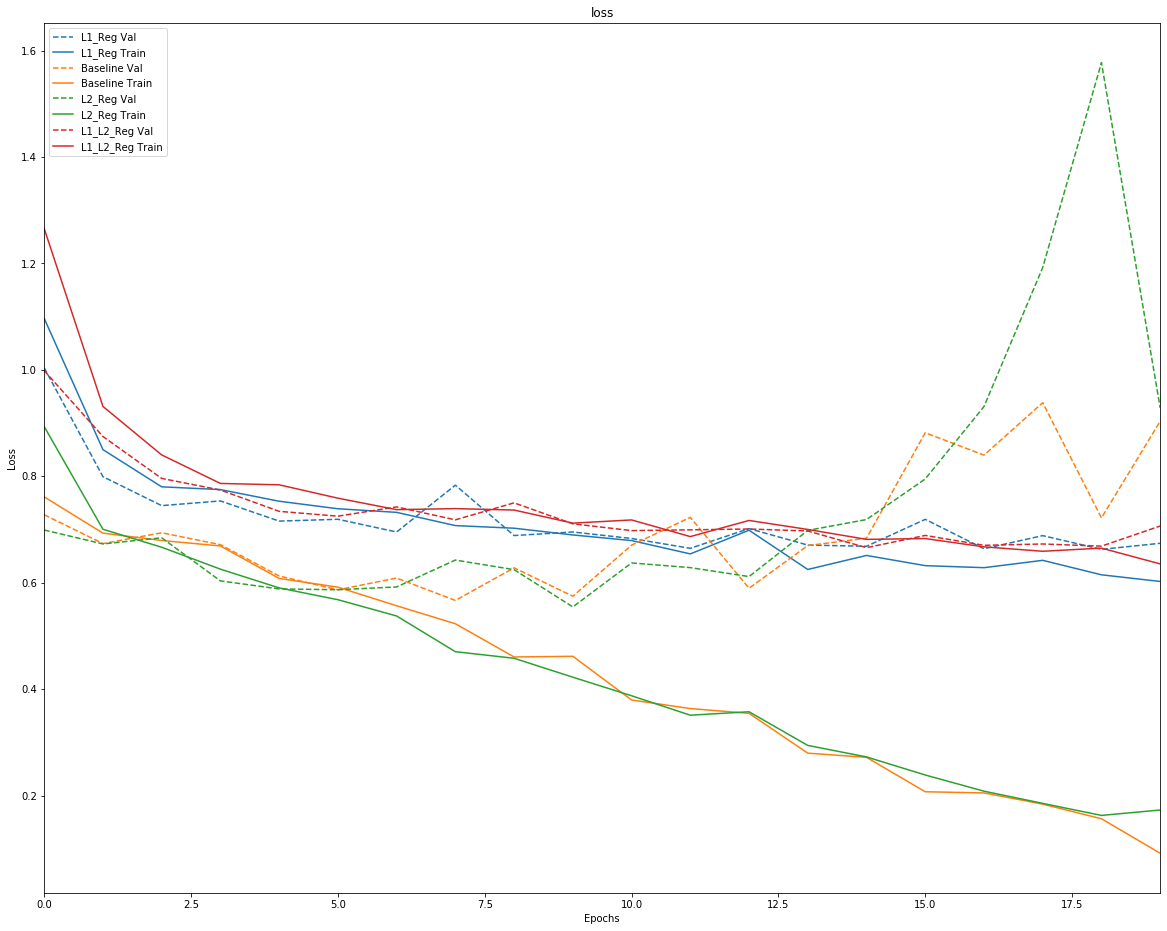

In [53]:
plot_histories([('l1_reg', hist_l1), 
                ('baseline', hist_base),
                ('l2_reg', hist_l2),
                ('l1_l2_reg', hist_l1l2)], keys=['loss'])

## Using dropout

Dropout is one of the most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 
1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.


In [54]:
from keras.layers import Dropout

def get_dropout_model(rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [55]:
m_drop = get_dropout_model()

m_drop.compile(optimizer="rmsprop",
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_drop = m_drop.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

W1009 01:27:08.888000 35184372383184 deprecation.py:506] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/20
31/31 [==============================] - 8s 250ms/step - loss: 0.7939 - acc: 0.5170 - val_loss: 0.6867 - val_acc: 0.5992
Epoch 2/20
31/31 [==============================] - 8s 243ms/step - loss: 0.6867 - acc: 0.5474 - val_loss: 0.6621 - val_acc: 0.5951
Epoch 3/20
31/31 [==============================] - 8s 242ms/step - loss: 0.6543 - acc: 0.6310 - val_loss: 0.6271 - val_acc: 0.6739
Epoch 4/20
31/31 [==============================] - 8s 244ms/step - loss: 0.6338 - acc: 0.6444 - val_loss: 0.6267 - val_acc: 0.6617
Epoch 5/20
31/31 [==============================] - 8s 243ms/step - loss: 0.5970 - acc: 0.6921 - val_loss: 0.5986 - val_acc: 0.6848
Epoch 6/20
31/31 [==============================] - 8s 244ms/step - loss: 0.5666 - acc: 0.7137 - val_loss: 0.5830 - val_acc: 0.7079
Epoch 7/20
31/31 [==============================] - 7s 237ms/step - loss: 0.5285 - acc: 0.7439 - val_loss: 0.5919 - val_acc: 0.6902
Epoch 8/20
31/31 [==============================] - 8s 244ms/step - loss: 0.

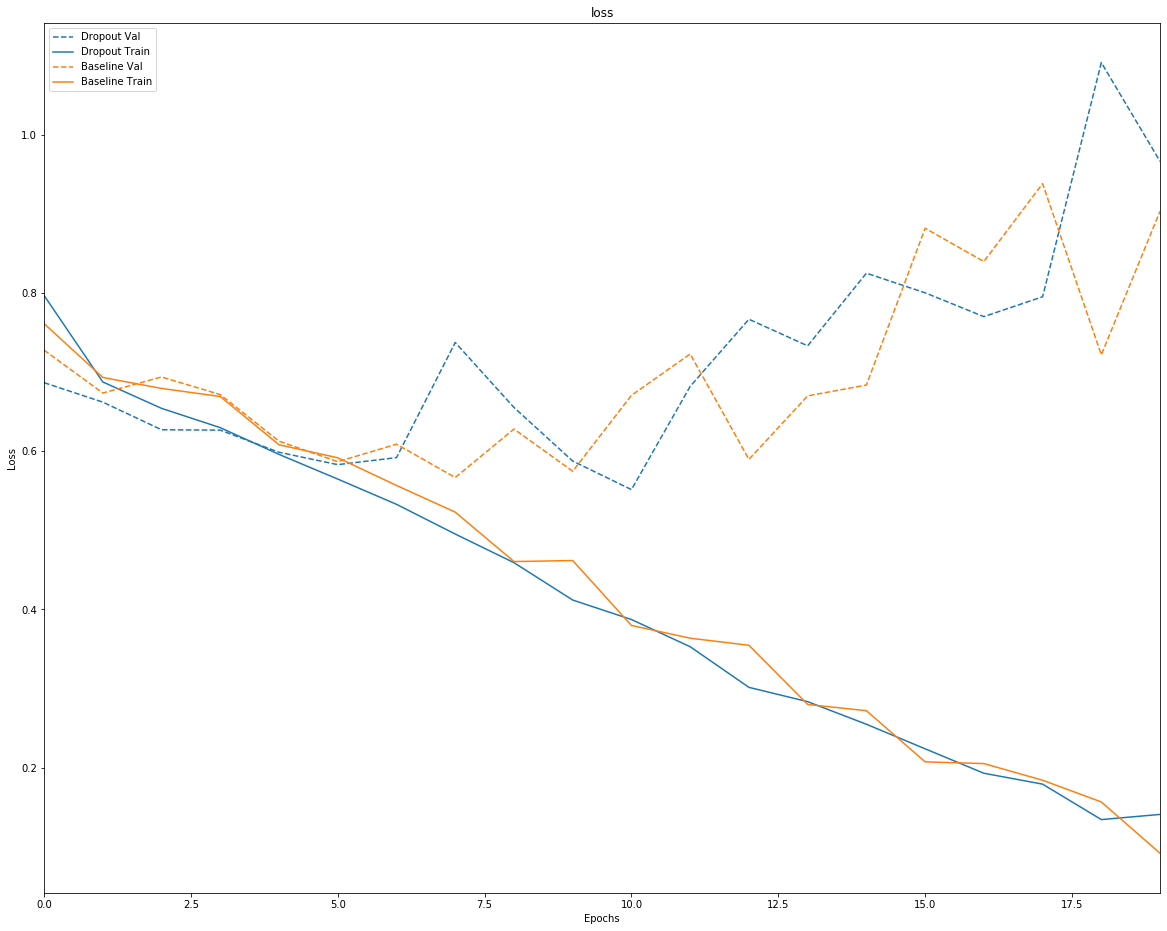

In [56]:
plot_histories([('dropout', hist_drop), 
                ('baseline', hist_base)], keys=['loss'])

Let's investigate the effect of a higher dropout rate.

In [57]:
m_more_drop = get_dropout_model(0.75)
m_more_drop.compile(optimizer="rmsprop",
                    loss="binary_crossentropy", 
                    metrics=['accuracy'])

hist_more_drop = m_more_drop.fit_generator(train_generator,
                                           epochs=epochs,
                                           steps_per_epoch=2000 // batch_size,
                                           validation_data=validation_generator,
                                           validation_steps=800 // batch_size)

W1009 01:29:42.476626 35184372383184 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/20
31/31 [==============================] - 8s 249ms/step - loss: 0.8916 - acc: 0.5085 - val_loss: 0.6904 - val_acc: 0.5910
Epoch 2/20
31/31 [==============================] - 8s 259ms/step - loss: 0.6878 - acc: 0.5503 - val_loss: 0.6873 - val_acc: 0.5690
Epoch 3/20
31/31 [==============================] - 8s 247ms/step - loss: 0.6809 - acc: 0.5591 - val_loss: 0.6544 - val_acc: 0.5910
Epoch 4/20
31/31 [==============================] - 8s 249ms/step - loss: 0.6562 - acc: 0.6069 - val_loss: 0.6599 - val_acc: 0.5938
Epoch 5/20
31/31 [==============================] - 8s 250ms/step - loss: 0.6341 - acc: 0.6547 - val_loss: 0.6230 - val_acc: 0.6726
Epoch 6/20
31/31 [==============================] - 8s 244ms/step - loss: 0.6049 - acc: 0.6804 - val_loss: 0.5950 - val_acc: 0.6902
Epoch 7/20
31/31 [==============================] - 8s 243ms/step - loss: 0.5891 - acc: 0.7022 - val_loss: 0.6138 - val_acc: 0.6603
Epoch 8/20
31/31 [==============================] - 7s 240ms/step - loss: 0.

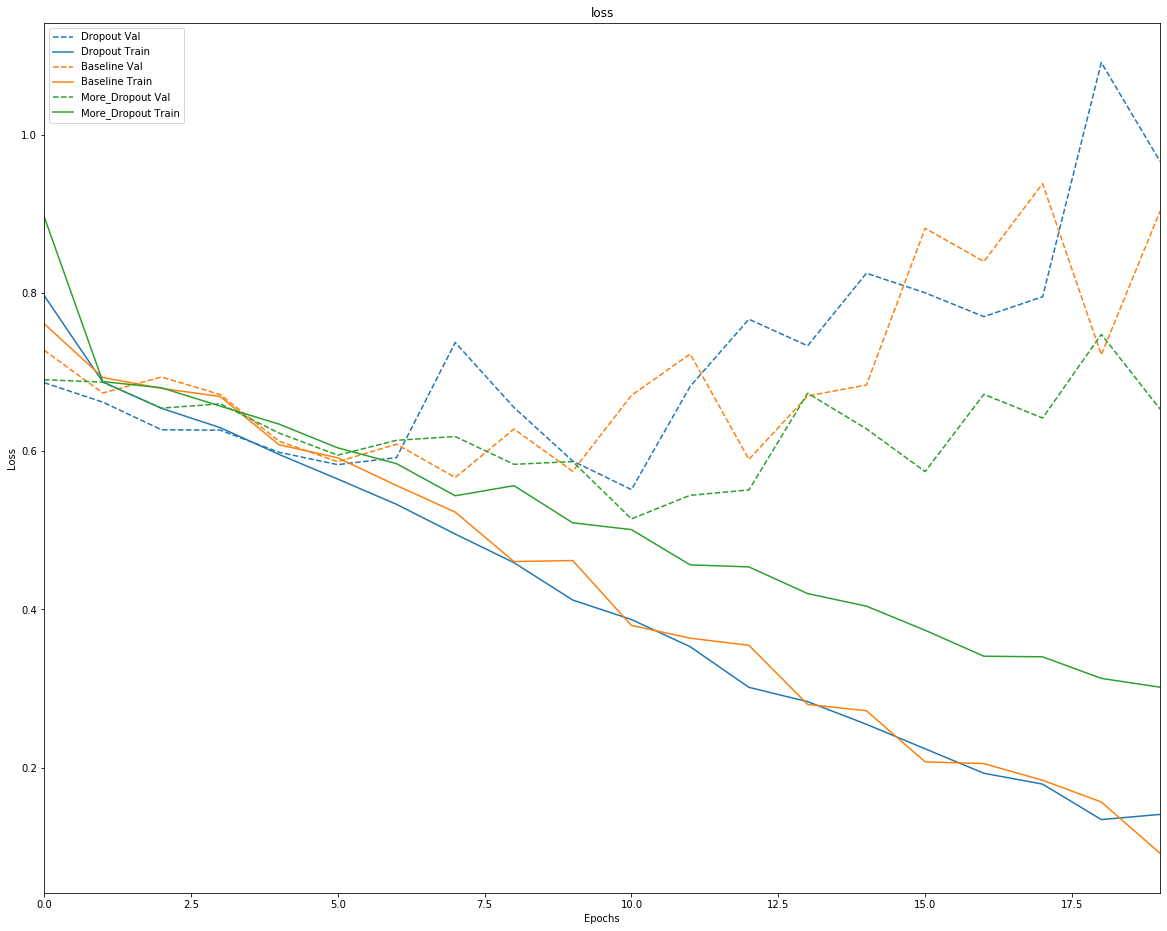

In [58]:
plot_histories([('dropout', hist_drop), 
                ('baseline', hist_base),
                ('more_dropout', hist_more_drop)], keys=['loss'])

## Using batch normalization

Intuitively you want the variances of each layers input of your network to be nice. You do not want them to go to zero nor do you want them to explode. Ideally you want everything be normalized throughout your network. 
Batch normalization is a new technique that does this: it just takes the batch mean and standard deviation of each of our features (i.e. for each pixel across the data) and then sets its value to be such that it has zero mean and unit variance.

It turns out that this function is differentiable and we can backpropagate it! By inserting now a batch normalization layer in our network we will take in as input some x and normalize it. So for a given input activation we can apply this normalization independently across our batch. So the hope is that by doing this the network will learn faster because it will not have to adapt to changes in the distribution of the inputs it receives.

Benefits of BN

- Improves gradient flow through network
- Allow higher learning rates
- Reduce strong dependency on initialization
- Acts as a form of regularization
- Note: 
    - at test time BN layer works differently
    - Mean and Std not computed based on batch (since you might want to predict single images)
    - Use a running mean and std. (maintained during training)

One more subtle issue is that it actually acts as a form of regularization. 
The way it acts as a regularizer is that with BN, if you have some input x, and it goes through the network then its representation in the network is also influenced by all the other examples in your batch since we use the batch mean and variance. 
So BN is using all the images of the batch a particular image was sampled in. So it randomizes the images position in the representation space which has a nice regularizing effect.

Note that at test time the BN layer acts differently. At test time, we want it to be a deterministic function. So we need to remember our mean and variance across the dataset. We can either compute it over all our data or much easier is to have a running mean and variance while training and then use that directly.

In [59]:
from keras.layers import BatchNormalization

def get_batchnorm_model():    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    return model

In [60]:
m_bn = get_batchnorm_model()

m_bn.compile(optimizer="rmsprop",
             loss="binary_crossentropy", 
             metrics=['accuracy'])

hist_bn = m_bn.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=2000 // batch_size,
                             validation_data=validation_generator,
                             validation_steps=800 // batch_size)

W1009 01:32:14.424484 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Epoch 1/20
31/31 [==============================] - 9s 276ms/step - loss: 0.6135 - acc: 0.6576 - val_loss: 0.5858 - val_acc: 0.7147
Epoch 2/20
31/31 [==============================] - 8s 269ms/step - loss: 0.5222 - acc: 0.7642 - val_loss: 0.7316 - val_acc: 0.5652
Epoch 3/20
31/31 [==============================] - 8s 256ms/step - loss: 0.4378 - acc: 0.8499 - val_loss: 0.5709 - val_acc: 0.7188
Epoch 4/20
31/31 [==============================] - 8s 243ms/step - loss: 0.3798 - acc: 0.9274 - val_loss: 0.6718 - val_acc: 0.5924
Epoch 5/20
31/31 [==============================] - 8s 272ms/step - loss: 0.3391 - acc: 0.9748 - val_loss: 0.6129 - val_acc: 0.6549
Epoch 6/20
31/31 [==============================] - 8s 253ms/step - loss: 0.3218 - acc: 0.9864 - val_loss: 0.5651 - val_acc: 0.7147
Epoch 7/20
31/31 [==============================] - 7s 242ms/step - loss: 0.3086 - acc: 0.9889 - val_loss: 0.5816 - val_acc: 0.6943
Epoch 8/20
31/31 [==============================] - 7s 224ms/step - loss: 0.

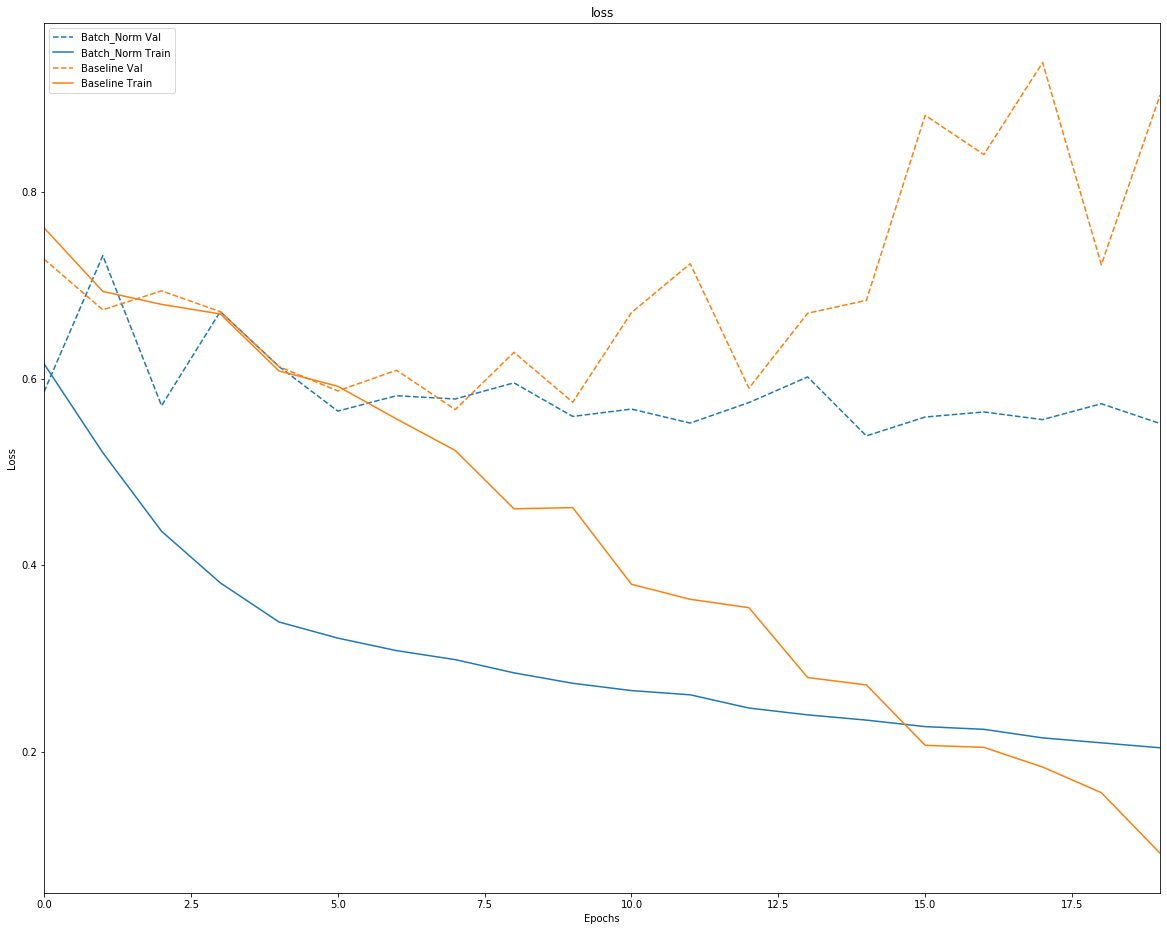

In [61]:
plot_histories([('batch_norm', hist_bn), 
                ('baseline', hist_base)], keys=['loss'])

## Using data augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.

In [62]:
# now we need to set up a different input pipeline that does the augmentation for us
train_datagen_aug = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator_aug = train_datagen_aug.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 2000 images belonging to 2 classes.


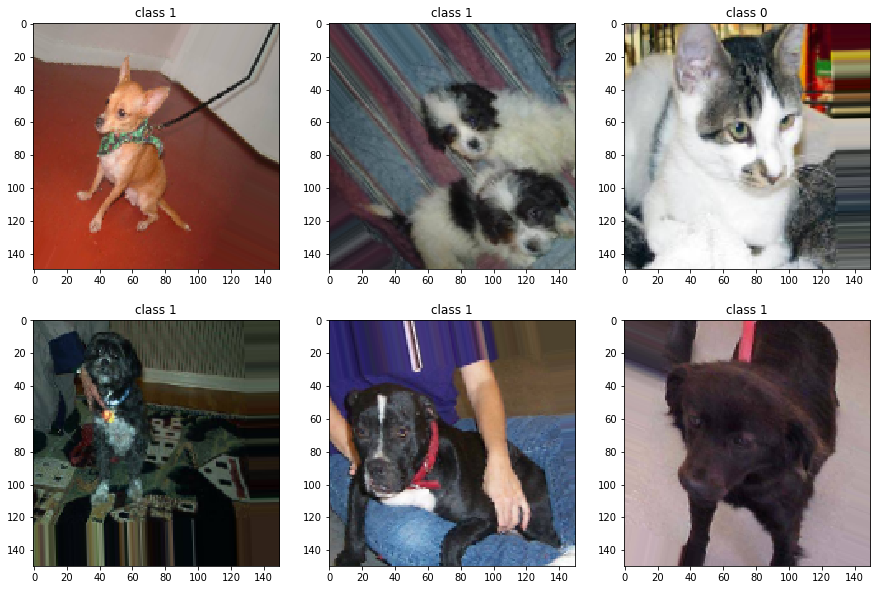

In [63]:
# plot some augmented images: on every execution you should get different images
img_batch, label_batch = train_generator_aug.next()
n_per_row = 3

plt.figure(figsize=(15, 10))
for i in range(n_per_row):
    plt.subplot(2, n_per_row, i + 1)
    plt.imshow(img_batch[i])
    plt.title("class " + str(int(label_batch[i])))

for i in range(n_per_row):
    plt.subplot(2, n_per_row, n_per_row + i + 1)
    plt.imshow(img_batch[n_per_row + i])
    plt.title("class " + str(int(label_batch[n_per_row + i])))
    
plt.show()

In [64]:
# during validation we do NOT augment the images of course
test_datagen_aug = ImageDataGenerator(rescale=1. / 255)
test_generator_aug = test_datagen_aug.flow_from_directory(
        validation_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels


Found 800 images belonging to 2 classes.


In [65]:
m_base = get_baseline_model()

m_base.compile(optimizer="rmsprop",
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_aug = m_base.fit_generator(train_generator_aug,
                                epochs=epochs,
                                steps_per_epoch=2000 // batch_size,
                                validation_data=test_generator_aug,
                                validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 17s 533ms/step - loss: 0.7583 - acc: 0.5221 - val_loss: 0.6880 - val_acc: 0.5091
Epoch 2/20
31/31 [==============================] - 17s 545ms/step - loss: 0.6930 - acc: 0.5398 - val_loss: 0.6726 - val_acc: 0.5829
Epoch 3/20
31/31 [==============================] - 18s 573ms/step - loss: 0.6784 - acc: 0.5892 - val_loss: 0.6651 - val_acc: 0.6332
Epoch 4/20
31/31 [==============================] - 17s 546ms/step - loss: 0.6739 - acc: 0.6000 - val_loss: 0.6401 - val_acc: 0.6019
Epoch 5/20
31/31 [==============================] - 17s 552ms/step - loss: 0.6686 - acc: 0.5958 - val_loss: 0.6670 - val_acc: 0.5516
Epoch 6/20
31/31 [==============================] - 17s 541ms/step - loss: 0.6662 - acc: 0.6124 - val_loss: 0.6157 - val_acc: 0.6685
Epoch 7/20
31/31 [==============================] - 18s 588ms/step - loss: 0.6341 - acc: 0.6596 - val_loss: 0.6032 - val_acc: 0.7038
Epoch 8/20
31/31 [==============================] - 16s 522ms/step - 

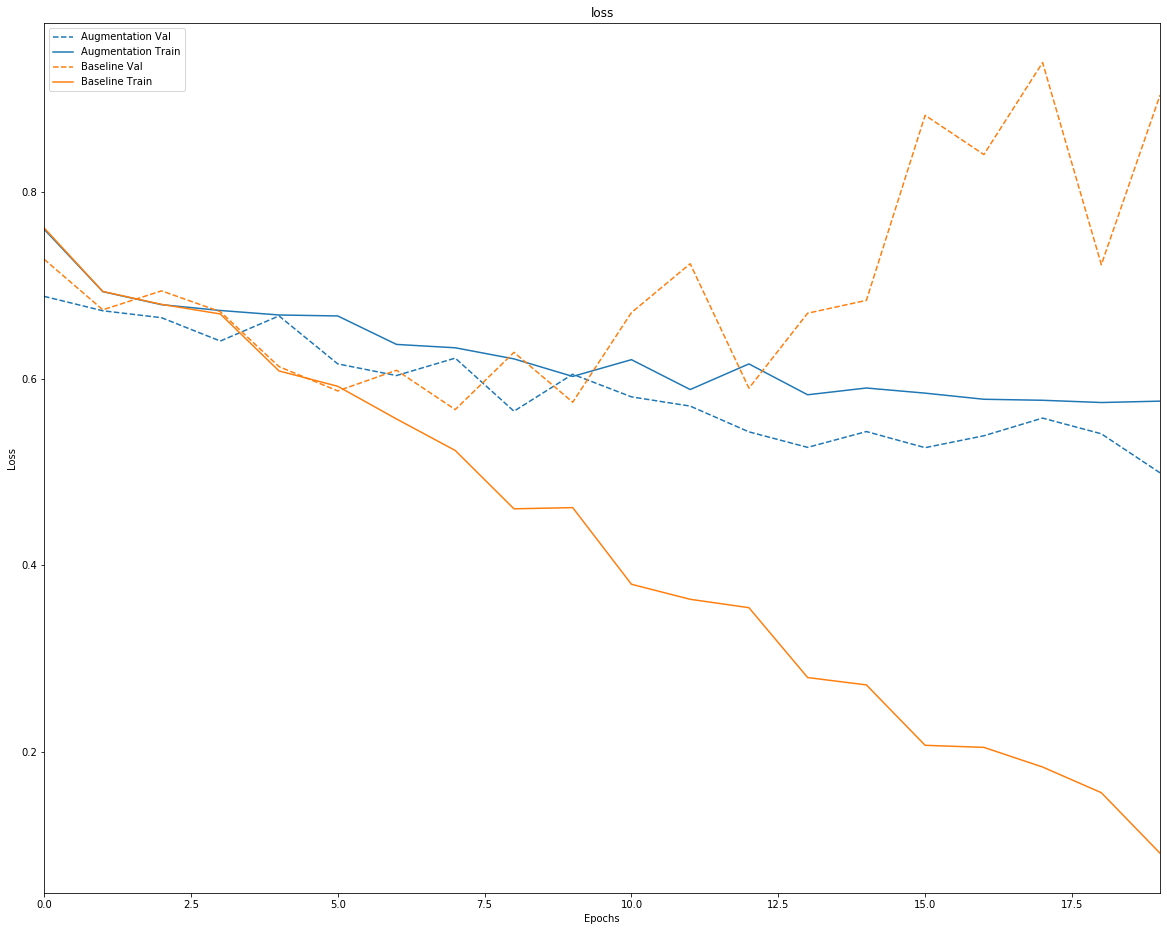

In [66]:
plot_histories([('augmentation', hist_aug),
                ('baseline', hist_base)], keys=["loss"])


### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
!kill -9 $temp